In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from numpy.fft import ifft as inverse_dft
import pandas as pd


In [2]:
# Class to compute exact distribution of S_n for discrete Markov Additive Process

In [3]:
class ValueMarkovChain():
    #markov chain that has associated value with each transition
    def __init__(self,T,V,pi):
        #T=transition matrix: T(k',k)=probability of transition from k' to k
        #V=value matrix V(k',k)=value of transition from k' to k (integer)
        self.T=T
        self.V=V
        self.pi=pi#initial distribution
        self.K=len(T) #number of states
        
        #verify inputs
        assert np.all(pi>=0)
        assert np.abs(np.sum(pi)-1)<10**-6
        assert T.shape==(self.K,self.K)
        assert V.shape==(self.K,self.K)
        assert T.min()>=0
        assert np.all(np.abs(T.sum(1)-np.ones(self.K))<10**-6)
        assert np.all(np.abs(V.astype('int')-V)<10**-6)
    def pgf(self,z,n):
        #evaluate probability generating function of S_n at complex value z
        #S_n=cumulative score after n states (n-1 transitions)
        A=self.T*z**(1.0*self.V)
        A=matrix_power(A,n-1)
        return (A.sum(1)*self.pi).sum()
    def get_distribution(self,n):
        #exact distribution of S_n
        #computed using fast fourier transform
        offset=max(np.max(-self.V),0)#largest negative value, or 0 if all entries are non-negative
        self.V=self.V+offset #convert to non-negative values
        N=np.max(self.V)*n+1 #maximal range of Y_n, corresponds to "n" in the numpy.fft implementation
        z0=np.exp(-2*np.pi*1j/N)
        ft=np.array([self.pgf(z0**k,n) for k in range(N)])
        p=inverse_dft(ft).real
        vals=np.arange(N)-offset*(n-1)
        self.V=self.V-offset #convert back to original values
        return vals,p

# Helper functions

In [4]:
def rho(M): #complex-valued spectral radius of a matrix
    evals=np.linalg.eig(M)[0]
    ids=np.argsort(np.abs(evals))
    return evals[ids[-1]]
def get_sr_moments(T,V,pi): #derivatives of spectral radius rho(Te^{tV}) at t=0
    K=len(T)
    Q=np.linalg.pinv(np.eye(K)-T)
    k1=(pi.T@(T*V)).sum()
    k2=(pi.T@(T*V*V)).sum()+2*((pi.T)@((T*V)@Q@(T*V))).sum()
    E1=T*V
    E2=T*V*V/2
    E3=T*V*V*V/6
    M=E3+E1@Q@E2+E2@Q@E1+E1@Q@(-k1*np.eye(K)+E1)@Q@E1
    k3=(pi.T@M).sum()
    return k1,k2,k3
    


In [5]:
#functions for generating string-counting transition matrix/value functions
def bin_exp(n,min_length=-1):
    #binary expansion with least significant digit first
    if n<2:
        return [n%2]+[0]*max(min_length-1,0)
    else:
        return [n%2]+bin_exp((n-n%2)//2,min_length=min_length-1)
def bin_to_int(b):
    #binary expansion with least significant digit first to integer
    if len(b)==0:
        return 0
    return b[0]+2*bin_to_int(b[1:])
def get_substring_T(L):
    #transition matrix for all substrings of length L
    T=np.zeros((2**(L),2**(L)))
    #each index corresponds to a binary string (least significant digit first)
    #say i<->s for some substring s
    #we can extract the last digits i-> (i-i%2)/2 
    #these should be the first digits of possible target so i'+2^{L-1} and i'
    for i in range(len(T)):
        i2=(i-i%2)//2
        T[i,i2]=1/2
        T[i,i2+2**(L-1)]=1/2
    return T

def sample_substring_problem(L):
    #sample random (centered) value function for the substring-transition matrix
    T=get_substring_T(L) #substring transition matrix
    pi=np.ones(len(T))/len(T) #uniform is always stationary distribution
    #value matrix with randomly selected targets
    V=np.zeros(T.shape).astype('int')
    xs,ys=np.where(T>0)
    v=np.random.choice(np.arange(-5,4),size=len(xs))
    i0=np.random.choice(len(xs))
    v[i0]-=v.sum() #ensure V is centered
    for xi,xj,c in zip(xs,ys,v):
        V[xi,xj]=c
    return T,V,pi

# Comparison of numerical values with asymptotic values

In [6]:
res=[]
n_range=[25,50,100,500]
for idx in range(100):
    T,V,pi=sample_substring_problem(4) #substring transition matrix + randomly-generated value function
    m0=ValueMarkovChain(T,V,pi)
    k1,k2,k3=get_sr_moments(T,V,pi) #derivatives of rho(Te^{tV}) at t=0
    analytic_val=-.5/k2**.5+k3/(k2)**1.5 #analytic value predicted by local limit theorem 
    for n in n_range:
        vals,probs=m0.get_distribution(n) #exact probability distribution of S_n
        est_val=(probs[vals<0].sum()-.5)*(2*np.pi*n)**.5
        res.append([idx,n,analytic_val,est_val])
res=pd.DataFrame(res,columns=['id','n','analytic','est'])


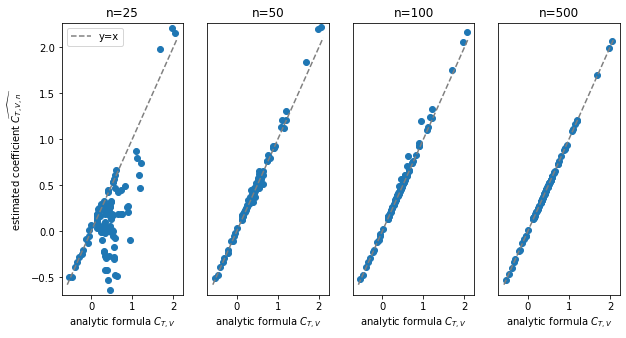

In [7]:
xmin=res['analytic'].min()
xmax=res['analytic'].max()
ymin=res['est'].min()
ymax=res['est'].max()
plt.figure(figsize=(10,5))
for i,n in enumerate(n_range):
    plt.subplot(1,4,i+1)
    res_n=res[res['n']==n]
    plt.scatter(res_n['analytic'],res_n['est'])
    plt.plot([xmin-.05,xmax+.05],[xmin-.05,xmax+.05],c='gray',linestyle='--',label='y=x')
    plt.xlabel('analytic formula $C_{T,V}$')
    plt.ylabel('estimated coefficient $\widehat{C_{T,V,n}}$' if i==0 else '')
    plt.title(f'n={n}')
    plt.ylim(ymin-.05,ymax+.05)
    if i>0:
        plt.yticks([])
    if i==0:
        plt.legend()